## Machine Learning Online Class 
##  Exercise 8 Part 2 | Collaborative Filtering
Requires : scipy

The collaborative filtering algorithm in the setting of movie recommendations considers a set of $n$-dimensional parameter vectors $x^{(1)}, x^{(2)}, ..., x^{(n_m)}$ and $\theta^{(1)}, \theta^{(2)}, ..., \theta^{(n_u)}$ where the model predicts the rating for movie $i$ by user $j$ as $y^{(i,j)}=(\theta^{(j)})^T x^{(i)}$ <br>
Given a dataset that consists of a set of ratings produced by some users on some movies, you wish to learn the parameter vectors
$x^{(1)}, ..., x^{(n_m)}, \theta^{(1)}, ..., \theta^{(n_u)}$ that produce the best fit (i.e minimize the squared error)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import re

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.optimize import minimize

%matplotlib inline

### Part 1: Loading movie ratings dataset
You will start by loading the movie ratings dataset to understand the structure of the data.

In [2]:
data = loadmat('ex8_movies.mat')
Y = data['Y']
R = data['R']

In [3]:
# Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies on 943 users
Y.shape

(1682, 943)

In [4]:
# R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a rating to movie i
R.shape

(1682, 943)

In [5]:
# From the matrix we can compute stats like average rating
# Average rating for movie 1 ("Toy story")

print('Average rating for Toy Story is : {:.6f}'.format(np.average(Y[0, np.argwhere(Y[0,:] > 0)])))
print('Average rating for Toy Story is : {:.6f}'.format(np.average(Y[0,R[0,:]==1])))

Average rating for Toy Story is : 3.878319
Average rating for Toy Story is : 3.878319


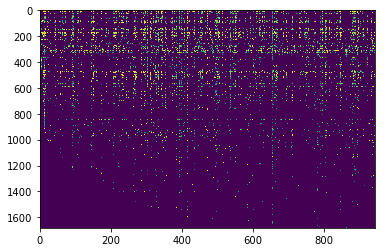

In [6]:
# We can "visualize" the ratings matrix 
plt.imshow(Y, aspect = 'auto')

### Part 2: Collaborative Filtering Cost Function (without regularization)
You will now implement the cost function for collaborative filtering.
To help you debug your cost function, we have included set of weights
that we trained on that. Specifically, you should complete the code in cofiCostFunc.m to return J.

The collaborative filtering cost function (without regularization) is :
$$ J(x^{(1)}, ..., x^{(n_m)}, \theta^{(1)}, ..., \theta^{(n_u)})= \frac{1}{2} \sum_{(i,j):r(i,j)=1} ((\theta^{(j)})^T x^{(i)}-y^{(i,j)})^2$$

In [7]:
def cofiCostFuncNoReg(params, Y, R, num_users, num_movies, num_features):
    
    # Unfold X and Theta matrices from matrices
    X = params[:num_movies*num_features].reshape(num_movies, num_features)
    Theta = params[num_movies*num_features:].reshape(num_users, num_features)
    
    return (1/2)*np.sum(((X.dot(Theta.T)-Y)**2)*R)    

In [8]:
# Load pre-trained weights
weights = loadmat('ex8_movieParams.mat')
X = weights['X']
Theta = weights['Theta']

In [9]:
# Reduce the data set size so that this runs faster
num_users = 4; num_movies = 5; num_features = 3;
X = X[:num_movies, :num_features]
Theta = Theta[:num_users, :num_features]
Y = Y[:num_movies, :num_users]
R = R[:num_movies, :num_users]

In [10]:
# Fold parameters
params = np.concatenate((X.flatten(),Theta.flatten()))

In [11]:
J = cofiCostFuncNoReg(params, Y, R, num_users, num_movies, num_features)
print('Cost at loaded parameters : {:.2f}'.format(J))
print('This value should be around 22.22')

Cost at loaded parameters : 22.22
This value should be around 22.22


### Part 3: Collaborative Filtering Gradient

The gradients of the cost function are given by :
$$\frac{\partial J}{\partial x_k^{(i)}}  = \sum_{j:r(i,j)=1} ((\theta^{(j)})^T x^{(i)}-y^{(i,j)}) \theta_k^{(j)} $$
$$\frac{\partial J}{\partial \theta_k^{(j)}}  = \sum_{i:r(i,j)=1} ((\theta^{(j)})^T x^{(i)}-y^{(i,j)})x_k^{(i)} $$

In [12]:
def cofiGradFuncNoReg(params, Y, R, num_users, num_movies, num_features):
    
    # Unfold X and Theta matrices from matrices
    X = params[:num_movies*num_features].reshape(num_movies, num_features)
    Theta = params[num_movies*num_features:].reshape(num_users, num_features)
    
    # Compute gradients
    X_grad = ((X.dot(Theta.T)-Y)*R).dot(Theta)
    Theta_grad = ((X.dot(Theta.T)-Y)*R).T.dot(X)
    
    # Fold
    return np.concatenate((X_grad.flatten(),Theta_grad.flatten()))      

##### Check gradients  (vs finite difference)

In [13]:
# Finite difference approx
def computeNumericalGradient(func, x):
    eps = 1e-4
      
    perturb = np.zeros(x.size)
    findiff = np.zeros(x.size)
    
    for p in range(x.size):
        perturb[p] = eps
        findiff[p] = (func(x + perturb) - func(x - perturb)) / (2 * eps)       
        perturb = np.zeros(x.size)       

        
    return findiff

In [14]:
def checkGradientNoReg():
    
    # Create a small problem
    X_t = np.random.rand(4,3)
    Theta_t = np.random.rand(5,3)
    
    # Zap out most entries
    Y = X_t.dot(Theta_t.T)
    Y[np.random.rand(Y.shape[0],Y.shape[1]) > 0.5] = 0
    
    R = np.zeros(Y.shape)
    R[Y != 0] = 1
    
    # Run gradient checking
    X = np.random.randn(X_t.shape[0], X_t.shape[1])
    Theta = np.random.randn(Theta_t.shape[0], Theta_t.shape[1])
    num_users = Y.shape[1]
    num_movies = Y.shape[0]
    num_features = Theta_t.shape[1]
    
    params = np.concatenate((X.flatten(),Theta.flatten()))
    
    numgrad = computeNumericalGradient(lambda p: cofiCostFuncNoReg(p, Y, R, num_users, num_movies, num_features), params)   
    grad = cofiGradFuncNoReg(params, Y, R, num_users, num_movies, num_features)
    
    result = np.c_[numgrad, grad]
    
    print("The following columns should be very similar \n")
    print("Left - Numerical Gradient, Right - Analytical Gradient\n")
    print(result)
    
    # Evaluate the norm of the difference
    diff = np.linalg.norm(numgrad - grad) / np.linalg.norm(numgrad + grad)
    
    print("If your implementation is correct, then")
    print("the relative difference will be small (less than 1e-9)\n")
    print("Relative difference : {}".format(diff))    

In [15]:
checkGradientNoReg()

The following columns should be very similar 

Left - Numerical Gradient, Right - Analytical Gradient

[[  1.13721576   1.13721576]
 [  1.10515605   1.10515605]
 [ -1.47903819  -1.47903819]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ -0.22143253  -0.22143253]
 [ 17.70912184  17.70912184]
 [-21.57302528 -21.57302528]
 [  0.71301124   0.71301124]
 [  2.33395297   2.33395297]
 [ -6.12808175  -6.12808175]
 [ 15.2795926   15.2795926 ]
 [-11.14944462 -11.14944462]
 [ 10.84188235  10.84188235]
 [  1.00309379   1.00309379]
 [ -0.66818421  -0.66818421]
 [  1.3762857    1.3762857 ]
 [ -4.31998735  -4.31998735]
 [  4.37129402   4.37129402]
 [ -2.0903636   -2.0903636 ]
 [ 10.09035342  10.09035342]
 [ -8.0268956   -8.0268956 ]
 [  6.03798653   6.03798653]
 [  0.70711695   0.70711695]
 [ -0.02860089  -0.02860089]
 [  1.32512603   1.32512604]]
If your implementation is correct, then
the relative difference will be small (less than 1e-9)

Relative differen

### Part 4: Collaborative Filtering Cost Regularization

The collaborative filtering cost function (with regularization) is :
$$ J(x^{(1)}, ..., x^{(n_m)}, \theta^{(1)}, ..., \theta^{(n_u)})= \frac{1}{2} \sum_{(i,j):r(i,j)=1} ((\theta^{(j)})^T x^{(i)}-y^{(i,j)})^2 + \frac{\lambda}{2}\sum_{j=1}^{n_u}\sum_{k=1}^{n} (\theta_k^{(j)})^2  + \frac{\lambda}{2}\sum_{i=1}^{n_m}\sum_{k=1}^{n} (x_k^{(i)})^2  $$

The collaborative filtering gradients (with regularization) are :
$$\frac{\partial J}{\partial x_k^{(i)}}  = \sum_{j:r(i,j)=1} ((\theta^{(j)})^T x^{(i)}-y^{(i,j)}) \theta_k^{(j)} + \lambda x_k^{(i)}$$
$$\frac{\partial J}{\partial \theta_k^{(j)}}  = \sum_{i:r(i,j)=1} ((\theta^{(j)})^T x^{(i)}-y^{(i,j)})x_k^{(i)} + \lambda \Theta_k^{(j)} $$

In [16]:
# Cost and grad functions with regularization
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lambda_reg = 0):
    
    # Unfold X and Theta matrices from matrices
    X = params[:num_movies*num_features].reshape(num_movies, num_features)
    Theta = params[num_movies*num_features:].reshape(num_users, num_features)
    
    return (1/2)*np.sum(((X.dot(Theta.T)-Y)**2)*R) + (lambda_reg / 2) * np.sum(np.sum(Theta**2)) + (lambda_reg / 2) * np.sum(np.sum(X**2))

In [17]:
def cofiGradFunc(params, Y, R, num_users, num_movies, num_features, lambda_reg = 0):
    
    # Unfold X and Theta matrices from matrices
    X = params[:num_movies*num_features].reshape(num_movies, num_features)
    Theta = params[num_movies*num_features:].reshape(num_users, num_features)
    
    # Compute gradients
    X_grad = ((X.dot(Theta.T)-Y)*R).dot(Theta) + lambda_reg * X
    Theta_grad = ((X.dot(Theta.T)-Y)*R).T.dot(X) + lambda_reg * Theta
    
    # Fold
    return np.concatenate((X_grad.flatten(),Theta_grad.flatten()))   

In [18]:
# Test cost function with regularization
J = cofiCostFunc(params, Y, R, num_users, num_movies, num_features, 1.5)
print('Cost at loaded parameters (lambda = 1.5) : {:.2f}'.format(J))
print('This value should be around 31.34')

Cost at loaded parameters (lambda = 1.5) : 31.34
This value should be around 31.34


### Part 5: Collaborative Filtering Gradient Regularization

In [19]:
# Gradeint checking. Same as below but with lambda
def checkGradient(lambda_reg = 0):
    
    # Create a small problem
    X_t = np.random.rand(4,3)
    Theta_t = np.random.rand(5,3)
    
    # Zap out most entries
    Y = X_t.dot(Theta_t.T)
    Y[np.random.rand(Y.shape[0],Y.shape[1]) > 0.5] = 0
    
    R = np.zeros(Y.shape)
    R[Y != 0] = 1
    
    # Run gradient checking
    X = np.random.randn(X_t.shape[0], X_t.shape[1])
    Theta = np.random.randn(Theta_t.shape[0], Theta_t.shape[1])
    num_users = Y.shape[1]
    num_movies = Y.shape[0]
    num_features = Theta_t.shape[1]
    
    params = np.concatenate((X.flatten(),Theta.flatten()))
    
    numgrad = computeNumericalGradient(lambda p: cofiCostFunc(p, Y, R, num_users, num_movies, num_features, lambda_reg), params)   
    grad = cofiGradFunc(params, Y, R, num_users, num_movies, num_features, lambda_reg)
    
    result = np.c_[numgrad, grad]
    
    print("The following columns should be very similar \n")
    print("Left - Numerical Gradient, Right - Analytical Gradient\n")
    print(result)
    
    # Evaluate the norm of the difference
    diff = np.linalg.norm(numgrad - grad) / np.linalg.norm(numgrad + grad)
    
    print("If your implementation is correct, then")
    print("the relative difference will be small (less than 1e-9)\n")
    print("Relative difference : {}".format(diff))   

In [20]:
# checking gradients (with regularization)
lambda_test = 1.5
checkGradient(lambda_test )

The following columns should be very similar 

Left - Numerical Gradient, Right - Analytical Gradient

[[ 7.28187343  7.28187343]
 [ 0.37280172  0.37280172]
 [ 3.08128003  3.08128003]
 [ 4.68536931  4.68536931]
 [ 4.52720718  4.52720718]
 [-2.64229983 -2.64229983]
 [ 0.17311045  0.17311045]
 [-1.5064766  -1.5064766 ]
 [-4.3273872  -4.3273872 ]
 [ 6.7433064   6.7433064 ]
 [ 3.09395465  3.09395465]
 [ 8.63375929  8.63375929]
 [-4.97455839 -4.97455839]
 [-2.10471397 -2.10471397]
 [-1.63427382 -1.63427382]
 [-4.24312398 -4.24312398]
 [ 1.87590782  1.87590782]
 [-3.45543252 -3.45543252]
 [ 5.88680942  5.88680942]
 [ 2.70753114  2.70753114]
 [-0.4380753  -0.4380753 ]
 [ 4.72390116  4.72390116]
 [ 2.8037743   2.8037743 ]
 [ 7.57664961  7.57664961]
 [-7.10007369 -7.10007369]
 [-2.61659504 -2.61659504]
 [ 0.38845261  0.38845261]]
If your implementation is correct, then
the relative difference will be small (less than 1e-9)

Relative difference : 2.7713673508429078e-12


###  Part 6: Entering ratings for a new user
Before we will train the collaborative filtering model, we will first add ratings that correspond to a new user that we just observed. <br>
This part of the code will also allow you to put in your own ratings for the movies in our dataset!

In [21]:
def loadMovieList():
    
    n = 1682
    
    # Initialize empty array
    movieList = np.array(['' for _ in range(n)], dtype=object) 
    
    with open('movie_ids.txt') as fp:  
        line = fp.readline()
        cnt = 0
        while line:    
            # print("{}".format(re.split("\d+\s+", line.strip(), maxsplit=1)[1]))
            movieList[cnt] = re.split("\d+\s+", line.strip(), maxsplit=1)[1]
            line = fp.readline()
            cnt += 1
            
    return movieList    

In [22]:
movieList = loadMovieList()

In [23]:
# Initialize my ratings
my_ratings = np.zeros((1682, 1))

In [24]:
# Check the file movie_idx.txt for id of each movie in our dataset
# For example, Toy Story (1995) has ID 0, so to rate it "4", you can set
my_ratings[0] = 4

In [25]:
# Or suppose did not enjoy Silence of the Lambs (1991), you can set
my_ratings[97] = 2

In [26]:
# We have selected a few movies we liked / did not like and the ratings we
# gave are as follows:
my_ratings[6] = 3
my_ratings[11]= 5
my_ratings[53] = 4
my_ratings[63]= 5
my_ratings[65]= 3
my_ratings[68] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354]= 5

In [27]:
print("New user ratings : ")
for el in np.argwhere(my_ratings !=0)[:,0]:
    print("Rated {} for".format(np.asscalar(my_ratings[el].astype('int'))), movieList[el])
    #print(my_ratings[el])

New user ratings : 
Rated 4 for Toy Story (1995)
Rated 3 for Twelve Monkeys (1995)
Rated 5 for Usual Suspects, The (1995)
Rated 4 for Outbreak (1995)
Rated 5 for Shawshank Redemption, The (1994)
Rated 3 for While You Were Sleeping (1995)
Rated 5 for Forrest Gump (1994)
Rated 2 for Silence of the Lambs, The (1991)
Rated 4 for Alien (1979)
Rated 5 for Die Hard 2 (1990)
Rated 5 for Sphere (1998)


### Part 7: Learning Movie Ratings
Now, you will train the collaborative filtering model on a movie rating dataset of 1682 movies and 943 users

In [28]:
# Reload data
data = loadmat('ex8_movies.mat')
Y = data['Y']
R = data['R']

In [29]:
# Add our own ratings to the data matrix
Y = np.c_[my_ratings, Y];
R = np.c_[(my_ratings!=0).astype('int'), R]

In [30]:
# Normalize Ratings by movie (so that each movie has a rating of 0 on average)

def normalizeRatings(Y,R):
    # Enters the power of masked arrays !!!
    # Mask Y values where R=0
    Y_masked = np.ma.masked_array(Y, mask = (R==0))
    
    # Compute mean on masked array
    Y_masked_mean = Y_masked.mean(axis = 1).reshape(-1,1)
    
    # Compute normalized matrix
    Ynorm_masked = Y_masked - Y_masked_mean
    
    # "Unmask" filling makes values with 0s
    Ynorm = np.ma.filled(Ynorm_masked, fill_value = 0)
    Ymean = np.ma.filled(Y_masked_mean, fill_value = 0)

    # 1 line
    # np.ma.filled((np.ma.masked_array(Y, mask = (R==0))- np.ma.masked_array(Y, mask = (R==0)).mean(axis = 1).reshape(-1,1)),fill_value = 0)
        
    return Ynorm, Ymean

In [31]:
Ynorm, Ymean =  normalizeRatings(Y,R)

In [32]:
# Useful values
num_movies, num_users = Y.shape
num_features = 10

In [33]:
# Set Initial Parameters (Theta, X) as random values from normalized gaussian
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)
initial_params = np.concatenate((X.flatten(),Theta.flatten()))

In [34]:
# Set regularization
lambda_reg = 10

find_optimal_params = minimize(fun=cofiCostFunc, x0=initial_params ,
method = 'cg', jac=cofiGradFunc, args = (Ynorm, R, num_users, num_movies, num_features, lambda_reg), options={'maxiter':100, 'disp':True})


         Current function value: 38952.172798
         Iterations: 100
         Function evaluations: 149
         Gradient evaluations: 149


In [35]:
# Unfold X and Theta matrices from matrices
X = find_optimal_params.x[:num_movies*num_features].reshape(num_movies, num_features)
Theta = find_optimal_params.x[num_movies*num_features:].reshape(num_users, num_features)

### Part 8: Recommendation for you
After training the model, you can now make recommendations by computing the predictions matrix.

In [36]:
p = X.dot(Theta.T)
my_predictions = p[:,0] + Ymean[:,0]

In [37]:
movieList = loadMovieList()

In [38]:
sorted_pred = my_predictions.argsort()[::-1]

print ('Top recommendations for you : ')

for i in range(20):
    print('Predicting rating {:.2f} for movie {}'.format(my_predictions[sorted_pred[i]], movieList[i]))   

Top recommendations for you : 
Predicting rating 5.00 for movie Toy Story (1995)
Predicting rating 5.00 for movie GoldenEye (1995)
Predicting rating 5.00 for movie Four Rooms (1995)
Predicting rating 5.00 for movie Get Shorty (1995)
Predicting rating 5.00 for movie Copycat (1995)
Predicting rating 5.00 for movie Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
Predicting rating 5.00 for movie Twelve Monkeys (1995)
Predicting rating 5.00 for movie Babe (1995)
Predicting rating 5.00 for movie Dead Man Walking (1995)
Predicting rating 5.00 for movie Richard III (1995)
Predicting rating 4.64 for movie Seven (Se7en) (1995)
Predicting rating 4.63 for movie Usual Suspects, The (1995)
Predicting rating 4.56 for movie Mighty Aphrodite (1995)
Predicting rating 4.52 for movie Postino, Il (1994)
Predicting rating 4.50 for movie Mr. Holland's Opus (1995)
Predicting rating 4.50 for movie French Twist (Gazon maudit) (1995)
Predicting rating 4.50 for movie From Dusk Till Dawn (1996)
Predicting rat

### END